# 使用xgboost库
## 目录
* xgboost中的参数
* 使用sklearn中xgboostAPI
    * 绘制学习曲线
    * 进化的学习曲线：方差与泛化误差
* 使用xgboost.train()
* 使用xgboost.cv()
    * 案例：在波士顿数据集上，使用xgb.cv这个类进行调参
* 分类案例：XGB中样本不均衡问题

## xgboost中的参数

|sklearn中参数|xgboost库中对应的参数名|集成算法|弱评估器|其他过程|含义|
|:--|:--|:--|:--|:--|:--|
|n_estimators|num_round|√|-|-|默认为100<br>建议优先调整n_estimators<br>一般不会建议太大的数目，以300以内为佳|
|learning_rate|eta|√|-|-|集成中的学习率<br>与n_estimators联合控制调参<br>取值范围[0,1]<br>设置太大模型可能无法收敛，设置太小模型速度非常缓慢|
|silent|silent|√|-|-|建议为True<br>True:不打印每次训练的结果|
|subsample|subsample|√|-|-|默认为1<br>随机抽样的时候抽取的样本比例，范围(0,1]<br>通常是在样本量本身很大的时候调整和使用|
|max_depth|max_depth|-|√|-|默认为6|
|objective|obj|-|√|-|确定使用的损失函数类型<br>可选的输入<br>reg:linear(使用线性回归的损失函数，均方误差)<br>binary:logistic(使用逻辑回归的损失函数，对数损失)<br>binary:hinge(使用支持向量机的损失函数,HingeLoss)<br>multi:softmax(使用softmax损失函数，多分类时使用)|
|booster|xgb_model|-|√|-|使用哪种弱评估器<br>默认为"gbtree"<br>可以输入gbtree(梯度提升树),gblinear(线性模型),dart(抛弃提升树，在建树的过程中会抛弃一部分树，更好的防过拟合)|
|gamma|gamma|-|√|-|“复杂度控制”，用来防止过拟合的重要参数。<br>同时还是让树停止生长的重要参数。<br>默认为0<br>取值范围[0,inf)<br>gamma越大，算法越保守，树的叶子数量越少，复杂度越低|
|min_child_weight|min_child_weight|-|√|-|默认为1<br>一个叶子结点上所需要的最小hi,即叶子结点上的二阶导数之和（类似于样本权重）|
|max_delta_step|max_delta_setp|-|√|-|在保证正确的概率的基础上，减轻样本不平衡问题带来的影响<br>树的权重估计中允许的单次最大增量<br>可以考虑成是影响wj的参数<br>可以将其设定为有限的数（比如1）来帮助收敛<br>很少使用|
|colsample_bytree|colsample_bytree|-|√|-|默认为1<br>每次生成树时随机抽样特征的比例|
|colsample_bylevel|colsample_bylevel|-|√|-|默认为1<br>每次生成树的一层时，随机抽样特征的比例|
|-|colsample_bynode|-|√|-|默认为1<br>每次生成一个叶子节点时，随机抽样特征的比例|
|reg_alpha|alpha|-|√|-|默认为0<br>取值范围为[0,inf)<br>正则化参数|
|reg_lambda|lambda|-|√|-|默认为1<br>取值范围为[0,inf)<br>正则化参数|
|nthread|nthread|-|-|√|用于运行xgboost的并行线程数（已弃用，请使用n_jobs）|
|n_jobs|n_jobs|-|-|√|用于运行xgboost的并行线程数|
|scale_pos_weight|scale_pos_weight|-|-|√|默认为1<br>调节样本不平衡的参数<br>类似随机森林和支持向量机中的class_weight参数<br>通常我们在参数中输入的是负样本量与正样本量之比|
|base_score|base_score|-|-|√|所有实例的初始预测分数，全局偏差<br>分类问题中，它是分类的先验概率<br>通常不使用这个参数<br>对于严重的样本不均衡问题，设置一个正确的base_score取值是很有必要的|
|seed|seed|-|-|√|随机数种子（已弃用，请使用random_state）|
|random_state|random_state|-|-|√|随机种子|
|missing|missing|-|-|√|需要作为缺失值存在的数据中的值<br>如果为None,默认为np.nan<br>输入一个对象或者数据的任意取值，表示将所有含有这个对象的数据作为空值处理|
|importance_type|importance_type|-|-|√|feature_importances_属性的特征重要性类型|

正则化参数往往不是我们调参的最优选择，如果真的希望控制模型的复杂度，我们会调整$\gamma$而不是调整这两个正则化参数.  
如果我们希望调整$\alpha$,$\lambda$，往往会使用网格搜索来帮助我们。


参数min_child_weight不太常用，它时一片叶子上的二阶导数$h_i$之和。当样本对应的二阶导数很小时，比如为0.01，min_child_weight若设定为1，则说明一片叶子上至少需要100个样本。  
本质上说，这个参数其实是在控制叶子上所需的最小样本量。因此对样本量很大的数据会比较有效。

**调参的过程**：  
通常在我们获得了一个数据集后，我们先使用网格搜索找出比较合适的n_estimators和eta组合  
然后使用gamma或者max_depth观察模型处于什么样的状态（过拟合还是欠拟合，处于方差-偏差图像的左边还是右边？）  
最后再决定是否要进行剪枝

## 使用sklearn中xgboostAPI

In [1]:
import xgboost
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score,KFold,train_test_split
from time import time
import datetime

In [2]:
boston = load_boston()
X = boston.data
y = boston.target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=420)

In [3]:
reg = xgboost.XGBRegressor(n_estimators=100).fit(X_train,y_train)
reg.score(X_test,y_test)

[17:38:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9197580267581366

In [4]:
[*zip(boston.feature_names,reg.feature_importances_)]

[('CRIM', 0.02474326),
 ('ZN', 0.0023391892),
 ('INDUS', 0.008951775),
 ('CHAS', 0.01757721),
 ('NOX', 0.048474625),
 ('RM', 0.25909728),
 ('AGE', 0.012036602),
 ('DIS', 0.042923097),
 ('RAD', 0.013585145),
 ('TAX', 0.025586879),
 ('PTRATIO', 0.04455473),
 ('B', 0.01763431),
 ('LSTAT', 0.48249587)]

可以查看模型的重要性分数，使用嵌入法进行特征选择

### 绘制学习曲线

In [5]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
train_sizes,train_scores,test_scores = learning_curve(xgboost.XGBRegressor(n_estimators=100),X_train,y_train,shuffle=True,cv=5,scoring="r2",random_state=420)

[17:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:43:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

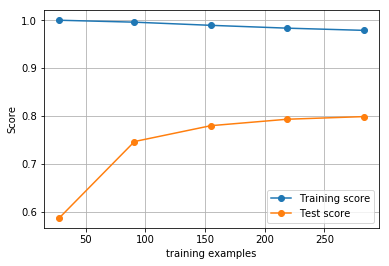

In [6]:
plt.grid()
plt.xlabel("training examples")
plt.ylabel("Score")
plt.plot(train_sizes,np.mean(train_scores,axis=1),"o-",label="Training score")
plt.plot(train_sizes,np.mean(test_scores,axis=1),"o-",label="Test score")
plt.legend(loc="best")

### 进化的学习曲线：方差与泛化误差
衡量模型在未知数据上的准确率的指标叫做，泛化误差(Genelization error)  
一个模型在位置数据集(D)上的泛化误差E，由方差(var),偏差(bais)和噪声($/epsilon$)共同决定。  
其中偏差就是训练集上的拟合程度决定，方差是模型的稳定性决定，噪声是不可控的。  
泛化误差越小，模型越理想。  
$$E(f;D)=bias^2+var+\epsilon^2$$

改进后的学习曲线，即考虑偏差也考虑方差

In [7]:
#改进后的学习曲线，将方差也考虑其中
cv = KFold(n_splits=5, shuffle = True, random_state=42) #交叉验证模式
n_estimators = np.arange(100,300,10)
bias = []#记录偏差
var = []#记录方差
Err = []#记录泛化误差中可控的部分

for i in n_estimators:
    reg = xgboost.XGBRegressor(n_estimators=i,random_state=420)
    CVresult = cross_val_score(reg,X_train,y_train,cv=cv)
    bias.append(CVresult.mean()) #记录偏差
    var.append(CVresult.var()) #记录方差
    Err.append((1-CVresult.mean())**2+CVresult.var())

bias = np.array(bias)
var = np.array(var)
Err = np.array(Err)

[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

when bias is min 180 0.8038787848970184 0.00959321570484315
when var is min 180 0.8038787848970184 0.00959321570484315
when Err is min 180 0.8038787848970184 0.00959321570484315


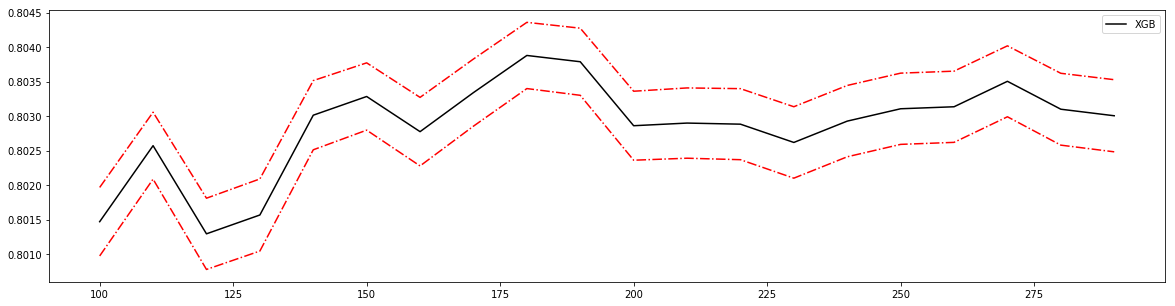

In [8]:
print("when bias is min",n_estimators[np.argmax(bias)],max(bias),var[np.argmax(bias)])
print("when var is min",n_estimators[np.argmin(var)],bias[np.argmin(var)],min(var))    
print("when Err is min",n_estimators[np.argmin(Err)],bias[np.argmin(Err)],var[np.argmin(Err)])

plt.figure(figsize=(20,5))
plt.plot(n_estimators,bias,c="black",label="XGB")
plt.plot(n_estimators,bias+var*0.05,c="red",linestyle="-.")
plt.plot(n_estimators,bias-var*0.05,c="red",linestyle="-.")
plt.legend()
plt.show()

## xgboost.train()的使用

使用xgboost库的建模流程  
1. 读取数据 xgboost.DMatrix()
2. 设置参数 param={}
3. 训练模型 bst = xgboost.train(param)
4. 预测结果 bst.predict()

In [10]:
import xgboost
#使用DMatrix类读取数据
dtrain = xgboost.DMatrix(X_train,y_train)
dtest = xgboost.DMatrix(X_test,y_test)

#写明参数
param = {
    'silent':False,
    "objective":"reg:linear",
    "eta":0.1
}
num_round = 180

#训练模型
bst = xgboost.train(param,dtrain,num_round)

#预测结果
predict = bst.predict(dtest)
from sklearn.metrics import r2_score
r2_score(y_test,predict)

[17:45:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9260984298390122

### 使用xgboost.cv()类

为了调整gamma，使用xgboost库中的类xgboost.cv  
xgboost.cv中用于回归和分类的评估指标有：
* rmse 均方根误差
* mae 绝对平均误差
* logloss 对数损失（二分类用）
* mlogloss 对数损失（多分类用）
* error 分类误差(1-准确率)
* auc AUC面积

在param中{“eval_metric”:"mae"}进行修改

In [11]:
#使用Dmatrix类读取数据
dfull = xgboost.DMatrix(X,y)

#设定参数
param_0 = {
'silent':True,'obj':'reg:linear',"gamma":0
#     "eval_metric":"rmse"
}
param_20 = {
    "silent":True,"obj":"reg:linear","gamma":20
}

num_round=180
n_fold=5

#使用类xgb.cv
time0 = time()
CVresult_0 = xgboost.cv(param_0,dfull,num_round,n_fold)
CVresult_20 = xgboost.cv(param_20,dfull,num_round,n_fold)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%s:%f"))

#看看类xgb.cv生成的结果
CVresult_0.head()

00:1:237792


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,17.105577,0.129117,17.163215,0.584297
1,12.337972,0.097556,12.519736,0.473458
2,8.994071,0.065756,9.404534,0.472310
3,6.629480,0.050323,7.250335,0.500342
4,4.954407,0.033209,5.920812,0.591874


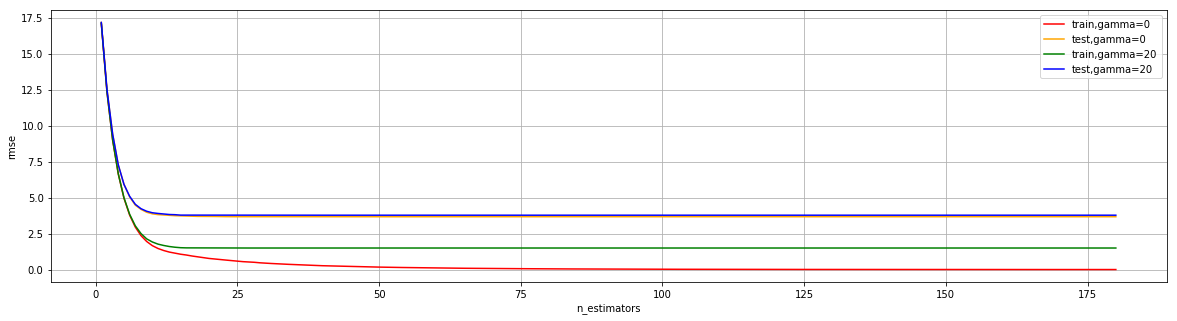

In [12]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,181),CVresult_0.iloc[:,0],c = "red",label="train,gamma=0")
plt.plot(range(1,181),CVresult_0.iloc[:,2],c = "orange",label="test,gamma=0")

plt.plot(range(1,181),CVresult_20.iloc[:,0],c = "g",label="train,gamma=20")
plt.plot(range(1,181),CVresult_20.iloc[:,2],c = "b",label="test,gamma=20")


plt.xlabel("n_estimators")
plt.ylabel("rmse")
plt.legend()
plt.show()

### 案例：在波士顿数据集上，使用xgb.cv这个类进行调参

In [15]:
dfull = xgboost.DMatrix(X,y)

param = {
    "silent":True,
    "obj":"reg:linear",#确定xgb所用的损失函数
    "subsample":1,
    "max_depth":6,
    "eta":0.3,
    "gamma":0,
    "lambda":1,
    "alpha":0,
    "colsample_bytree":1,
    "colsample_bylevel":1,
    "colsample_bynode":1,
    "nfold":5,
#     "eval_metric":"rmse"
}
num_round=200

time0 = time()
CVresult = xgboost.cv(param,dfull,num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%s:%f"))

00:0:331057


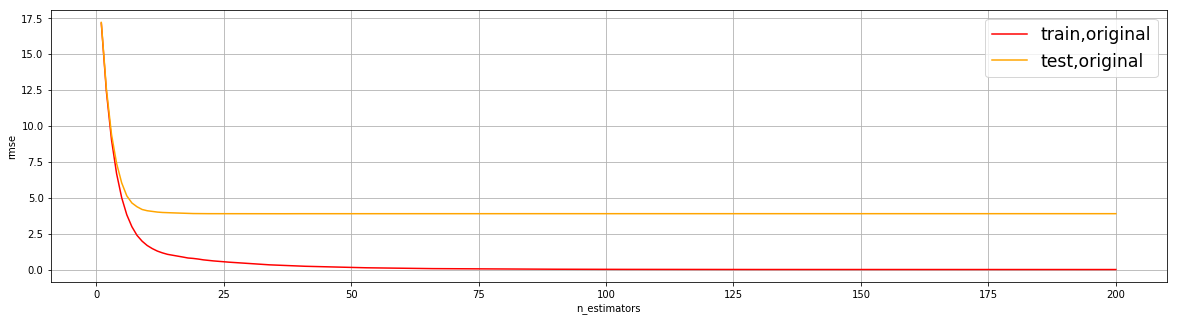

In [16]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,201),CVresult.iloc[:,0],c = "red",label="train,original")
plt.plot(range(1,201),CVresult.iloc[:,2],c = "orange",label="test,original")

plt.xlabel("n_estimators")
plt.ylabel("rmse")
plt.legend(fontsize="xx-large")#让图例的字体最大

plt.show()

从曲线上可以看出，模型现在处于过拟合的状态，我们决定剪枝。  
我们的目标是：训练集和测试集的结果尽量接近。  
在这里我们使用三组曲线，一组用于展示原式数据集上的结果，一组用于展示上一个参数调整完毕后的结果，最后一组用于展示现在我们在调节的参数的结果

00:0:332620


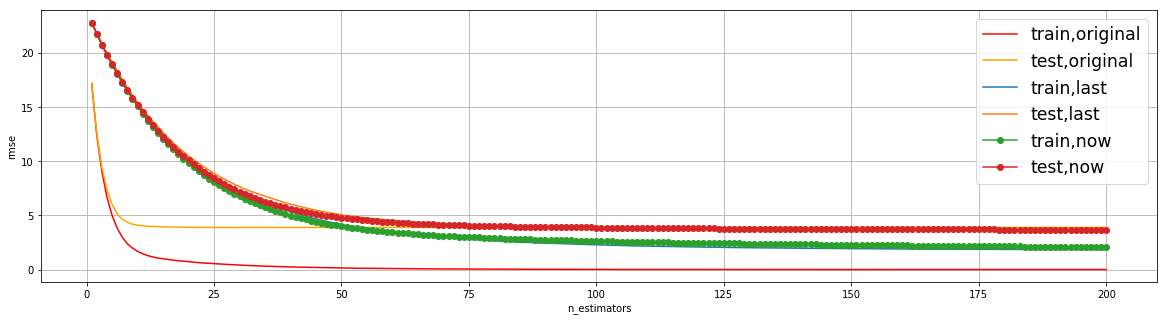

In [18]:
param_original = {
    "silent":True,
    "obj":"reg:linear",#确定xgb所用的损失函数
    "subsample":1,
    "max_depth":6,
    "eta":0.3,
    "gamma":0,
    "lambda":1,
    "alpha":0,
    "colsample_bytree":1,
    "colsample_bylevel":1,
    "colsample_bynode":1,
    "nfold":5,
#     "eval_metric":"rmse"
}
num_round=200

time0 = time()
CVresult_original = xgboost.cv(param_original,dfull,num_round)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%s:%f"))

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,201),CVresult.iloc[:,0],c = "red",label="train,original")
plt.plot(range(1,201),CVresult.iloc[:,2],c = "orange",label="test,original")


param_last = {
    "silent":True,
    "obj":"reg:linear",#确定xgb所用的损失函数
    "subsample":1,
    "max_depth":4,
    "eta":0.05,
    "gamma":20,
    "lambda":3.5,
    "alpha":0.2,
    "colsample_bytree":0.4,
    "colsample_bylevel":0.6,
    "colsample_bynode":1,
    "nfold":5,
#     "eval_metric":"rmse"
}


param_now = {
    "silent":True,
    "obj":"reg:linear",#确定xgb所用的损失函数
    "subsample":1,
    "max_depth":2,
    "eta":0.05,
    "gamma":0,
    "lambda":1,
    "alpha":0,
    "colsample_bytree":1,
    "colsample_bylevel":0.4,
    "colsample_bynode":1,
    "nfold":5,
#     "eval_metric":"rmse"
}

CVresult_last = xgboost.cv(param_last,dfull,num_round)
CVresult_now = xgboost.cv(param_now,dfull,num_round)

plt.plot(range(1,201),CVresult_last.iloc[:,0],label="train,last")
plt.plot(range(1,201),CVresult_last.iloc[:,2],label="test,last")

plt.plot(range(1,201),CVresult_now.iloc[:,0],"o-",label="train,now")
plt.plot(range(1,201),CVresult_now.iloc[:,2],"o-",label="test,now")


plt.xlabel("n_estimators")
plt.ylabel("rmse")
plt.legend(fontsize="xx-large")#让图例的字体最大
plt.show()

调整中的问题：  
1. 一个个参数调整太麻烦，可不可以使用网格搜索？  
    建议先使用xgboost.cv来确认参数的范围，否则很可能花很长时间做了无用功。  
    并且，在使用网格搜索的时候，最好不要一次性将所有的参数都放入进行搜索，最多一次两三个。  
    一些互相影响的参数需要放在一起使用，比如学习率eta和n_estimators 
    
2. 调参的顺序会影响调参结果吗？  
  会影响  
  在现实中，我们会优先调整那些对模型影响巨大的参数。  
  建议的剪枝调参顺序为：  
  * n_estimators与eta共同调节  
  * gamma或者max_depth
  * 采样和抽样参数（纵向抽样影响更大）
  * 正则化的两个参数

## 分类案例：XGB中样本不均衡问题
通过调节scale_pos_weight参数来进行  
通常scale_pos_weight=负样本数之和/正样本数之和

In [19]:
#创建样本不均衡的数据集
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,recall_score,roc_auc_score

class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2有50个样本
centers = [[0,0],[2,2]] #设定两个类别的中心
clusters_std = [1.5,0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散

X,y = make_blobs(
    n_samples=[class_1,class_2],
    centers = centers,
    cluster_std = clusters_std,
    random_state = 0,
    shuffle = False
)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=420)

**在数据集上建模：sklearn模式**

In [20]:
clf = xgboost.XGBClassifier()
clf.fit(X_train,y_train)
predict = clf.predict(X_test)
clf.score(X_test,y_test)

0.9272727272727272

In [21]:
confusion_matrix(y_test,predict,labels=[1,0])

array([[  9,   4],
       [  8, 144]])

In [22]:
recall_score(y_test,predict)

0.6923076923076923

In [23]:
roc_auc_score(y_test,predict)

0.819838056680162

In [24]:
## 调整scale_pos_weight参数
clf_ = xgboost.XGBClassifier(scale_pos_weight=10).fit(X_train,y_train)
predict_ = clf_.predict(X_test)
clf_.score(X_test,y_test)

0.9515151515151515

In [25]:
confusion_matrix(y_test,predict_,labels=[1,0])

array([[ 13,   0],
       [  8, 144]])

In [26]:
recall_score(y_test,predict_)

1.0

In [27]:
roc_auc_score(y_test,predict_)

0.9736842105263158

调整scale_pos_weight后，模型的准确率有了很大提高

**在数据集上建模：xgboost模式**

In [29]:
dtrain = xgboost.DMatrix(X_train,y_train)
dtest = xgboost.DMatrix(X_test)

param={
    "slient":True,
    "objective":"binary:logistic",
    "eta":0.1,
    "scale_pos_weight":1
}
num_round=100

bst = xgboost.train(param,dtrain,num_round)
preds = bst.predict(dtest)

In [30]:
preds[:5]

array([0.00110357, 0.00761518, 0.00110357, 0.00110357, 0.93531454],
      dtype=float32)

返回的是预测概率，需要改成类别

In [31]:
preds[preds > 0.5] = 1
preds[preds != 1] = 0

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,preds)

0.9272727272727272

修改scale_pos_weight

In [33]:
param={
    "slient":True,
    "objective":"binary:logistic",
    "eta":0.1,
    "scale_pos_weight":10
}
num_round=100

bst = xgboost.train(param,dtrain,num_round)
preds = bst.predict(dtest)

preds[preds > 0.5] = 1
preds[preds != 1] = 0

accuracy_score(y_test,preds)

0.9515151515151515

也可以通过调整不同的阈值来进行调整